In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D



from IPython import display

import numpy as np
import pandas as pd

In [3]:
class GA():
    
    # nums N * M 
    #     N-->种群中的个体个数 M-->DNA个数
    # bound 每个DNA的边界  [(0.0,1.1),(-11,+123)....]
    # func
    # DNA_SIZE 可以指定大小None时自动分配
    def __init__(self,nums,bound,func,DNA_SIZE = None,cross_rate = 0.8,mutation = 0.003):
        nums = np.array(nums) 
        bound = np.array(bound)
        self.bound = bound
        if nums.shape[1] != bound.shape[0]:
            raise Exception('DNA nums and its bound is different,you have {nums.shape[1]} DNA,but {bound.shape[0] bounds}')
            
            
        for var in nums:
            for index, var_curr in enumerate(var):
                if var_curr < bound[index][0] or var_curr > bound[index][1]:
                    raise Exception('{var_curr} not in range!')
        
        for min_bound,max_bound in bound:
            if max_bound < min_bound:
                raise Exception('Sorry,({min_bound},{max_bound}) not the right range')
                
        min_nums,max_nums = np.array(list(zip(*bound)))   # 与 zip 相反，*bound 可理解为解压
        self.var_len = var_len = max_nums - min_nums
        bits = np.ceil(np.log2(var_len+1)) # ceil 向上取整
        
        if DNA_SIZE == None:
            DNA_SIZE = int(np.max(bits))
        self.DNA_SIZE = DNA_SIZE
        
       
        self.POP_SIZE = len(nums)
        POP = np.zeros((*nums.shape,DNA_SIZE))
        
        for i in range(nums.shape[0]):
            for j in range(nums.shape[1]):

                num = int(round((nums[i,j] - bound[j][0]) * ((2**DNA_SIZE) / var_len[j])))

                POP[i,j] = [int(k) for k in ('{0:0' + str(DNA_SIZE) +'b}').format(num)]

       
        self.POP = POP
        self.copy_POP = POP.copy()
        self.cross_rate = cross_rate
        self.mutation = mutation
        self.func = func 
        
        
#        bound                取值范围
#        var_len              取值范围大小
#        POP_SIZE             种群大小
#        POP                  编码后的种群[[[1,0,1,...],[1,1,0,...],...]]
#                             一维元素是各个种群，二维元素是各个DNA[1,0,1,0]，三维元素是碱基对1/0
#        copy_POP             复制的种群，用于重置
#        cross_rate           染色体交换概率
#        mutation             基因突变概率
#        func                 适应度函数        
                                             
                                             
                                             
                                             
        
        
    # Decode
    def translateDNA(self):
        W_vector = np.array([2**i for i in range(self.DNA_SIZE)]).reshape((self.DNA_SIZE,1))[::-1]
        binary_vector = self.POP.dot(W_vector).reshape(self.POP.shape[0:2])
        for i in range(binary_vector.shape[0]):
            for j in range(binary_vector.shape[1]):
                binary_vector[i,j] /= ((2**self.DNA_SIZE)/self.var_len[j])
                binary_vector[i,j] += self.bound[j][0]
        return binary_vector
    
    # Fitness
    def get_fitness(self,non_negative=False):
        result = self.func(*np.array(list(zip(*self.translateDNA()))))
        if non_negative:
            min_fit = np.min(result,axis=0)
            if (result == min_fit).all():
                pass
            else:
                result -= min_fit
        return result
    
    
    # Selection
    def select(self):
        fitness = self.get_fitness(non_negative=True)
        self.POP = self.POP[np.random.choice(np.arange(self.POP.shape[0]), size=self.POP.shape[0], replace=True, p=fitness/np.sum(fitness))]


        
    # Crossover
    def crossover(self):
        for people in self.POP:
            if np.random.rand() < self.cross_rate:
                i_ = np.random.randint(0, self.POP.shape[0], size=1)
                cross_points = np.random.randint(0, 2, size=(len(self.var_len) ,self.DNA_SIZE)).astype(np.bool) 
                people[cross_points] = self.POP[i_, cross_points]
                
    # Mutate
    def mutate(self):
        for people in self.POP:
            for var in people:
                for point in range(self.DNA_SIZE):
                    if np.random.rand() < self.mutation:
                        var[point] = 1 if var[point] == 0 else 1
    
    # Evolution
    def evolution(self):
        self.select()
        self.crossover()
        self.mutate()
    
    # Reset
    def reset(self):
        self.POP = self.copy_POP.copy()
    
    # Log
    def log(self):
        return pd.DataFrame(np.hstack((self.translateDNA(), self.get_fitness().reshape((len(self.POP),1)))), 
                        columns=[f'x{i}' for i in range(len(self.var_len))]+['F'])
    
    def plot_in_jupyter_1d(self,iter_time=200):
        is_ipython = 'inline' in matplotlib.get_backend()
        if is_ipython:
            from IPython import display

        plt.ion()
        for _ in range(iter_time):
            plt.cla()
            x = np.linspace(*self.bound[0], self.var_len[0]*50)
            plt.plot(x, self.func(x))
            x = self.translateDNA().reshape(self.POP_SIZE)
            plt.scatter(x, self.func(x), s=200, lw=0, c='red', alpha=0.5)
            if is_ipython:
                display.clear_output(wait=True)
                display.display(plt.gcf())

            self.evolution()
    
    

In [70]:
# DNA_SIZE = None
# bound = [(12,13),(4,5),(-1,1)]
# min_nums,max_nums = np.array(list(zip(*bound)))   # 与 zip 相反，*bound 可理解为解压
# var_len = max_nums - min_nums
# bits = np.ceil(np.log2(var_len+1)) # ceil 向上取整

# if DNA_SIZE == None:
#     DNA_SIZE = int(np.max(bits))

# POP_SIZE = len(nums)
# POP = np.zeros((*nums.shape,DNA_SIZE))

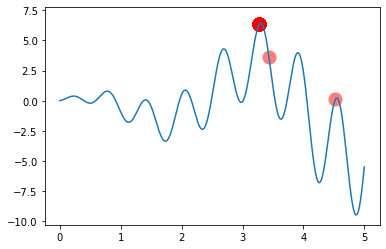

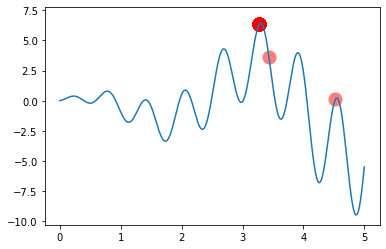

In [77]:
func = lambda x:np.sin(10*x)*x + np.cos(2*x)*x
ga = GA([[np.random.rand()*5] for _ in range(100)], [(0,5)], DNA_SIZE=10, func=func)
ga.plot_in_jupyter_1d()

In [78]:
ga.log().max()

x0    3.276367
F     6.353263
dtype: float64

In [72]:
nums = list(zip(np.arange(-2, 2, 0.2), np.arange(-2, 2, 0.2)))
bound = [(-2, 2), (-2, 2)]
func = lambda x, y: x*np.cos(2*np.pi*y)+y*np.sin(2*np.pi*x)
DNA_SIZE = 20
cross_rate = 0.7
mutation = 0.01

ga = GA(nums=nums, bound=bound, func=func, DNA_SIZE=DNA_SIZE, cross_rate=cross_rate, mutation=mutation)

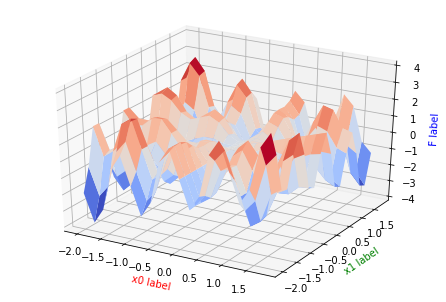

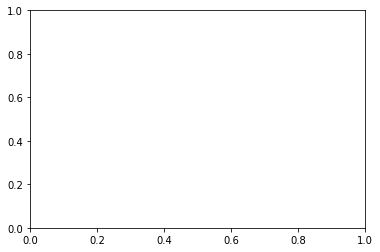

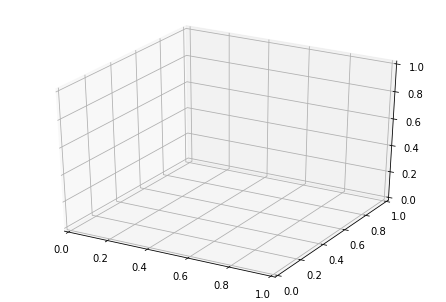

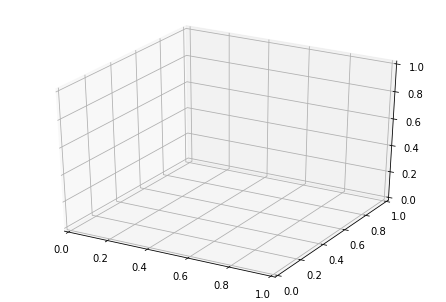

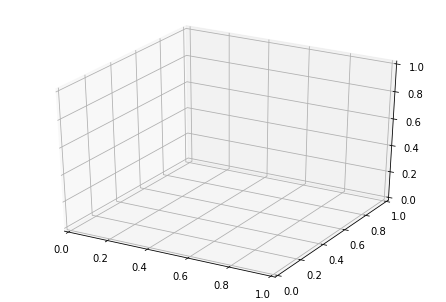

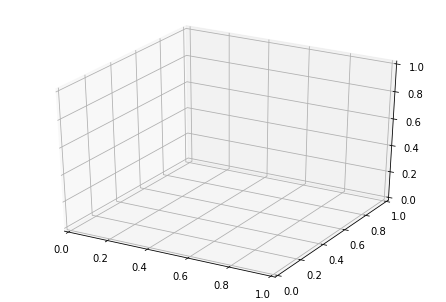

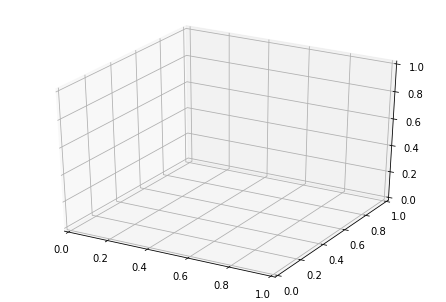

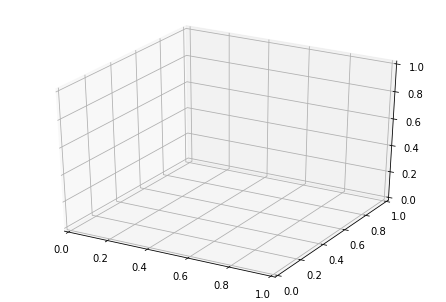

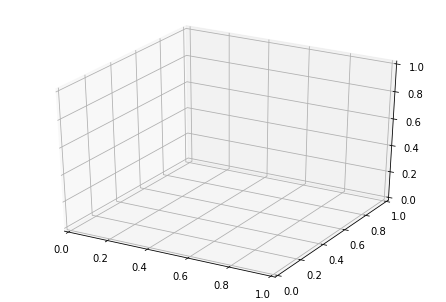

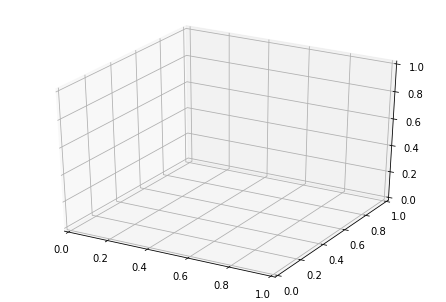

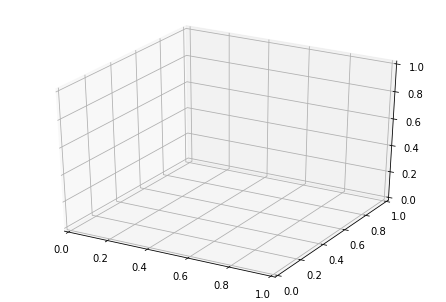

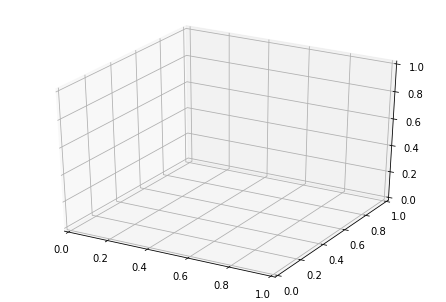

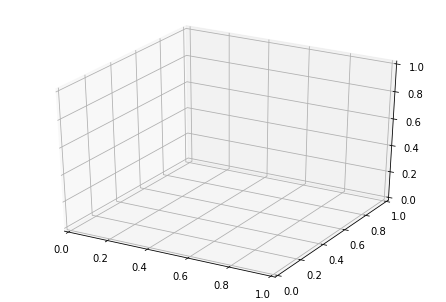

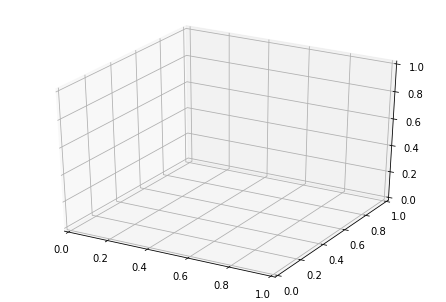

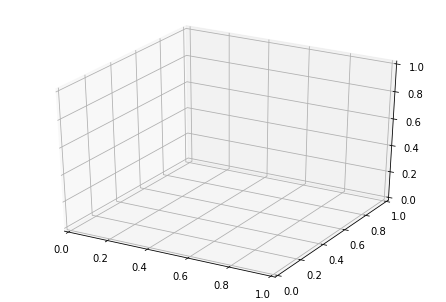

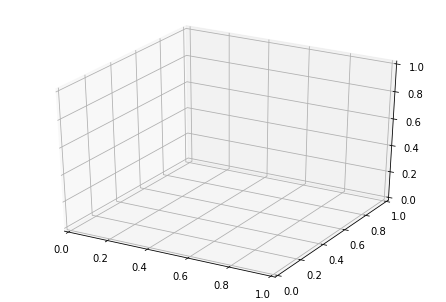

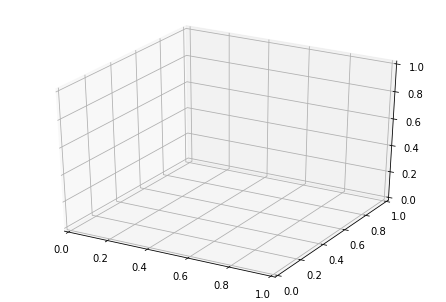

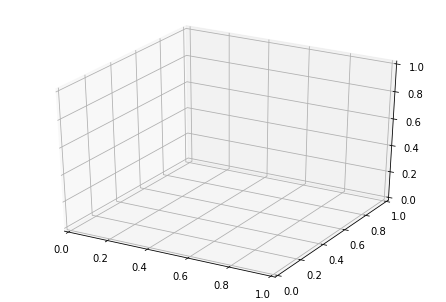

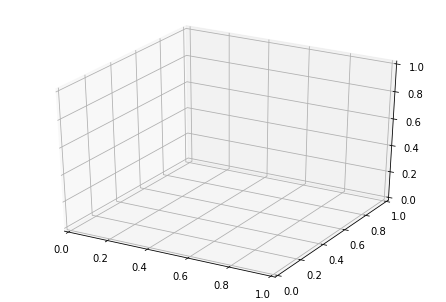

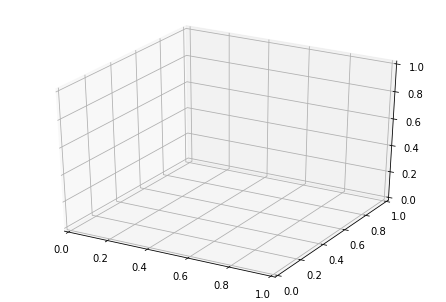

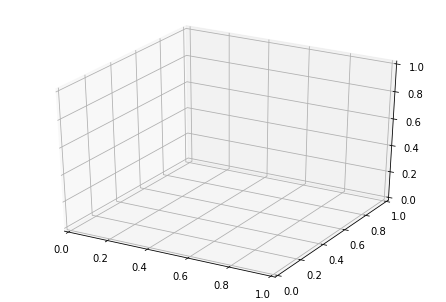

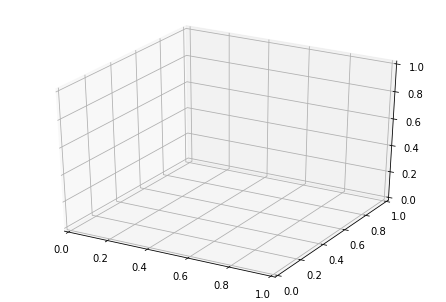

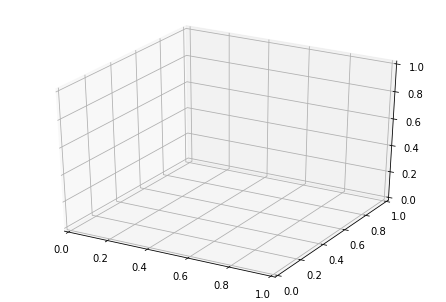

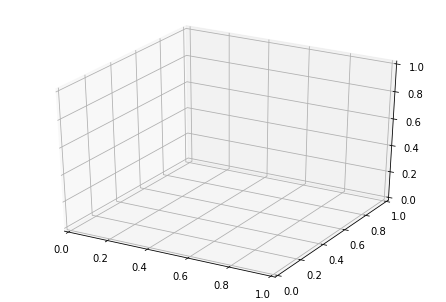

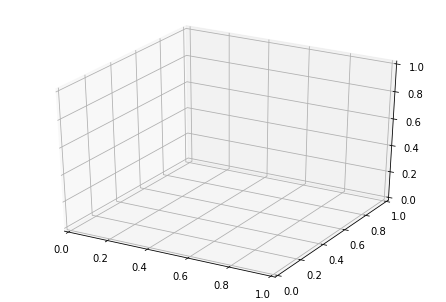

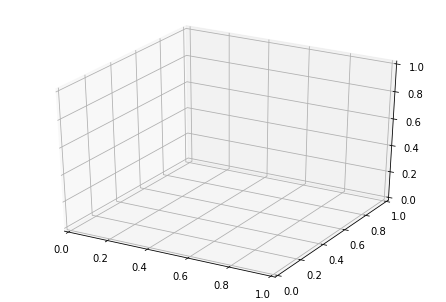

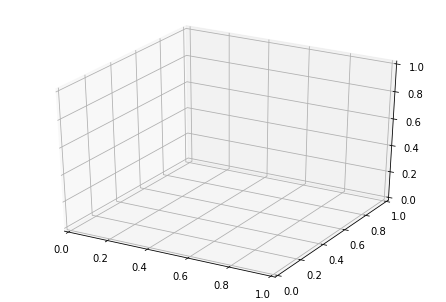

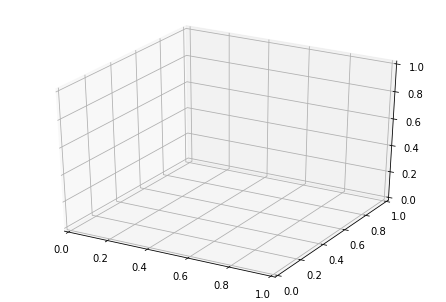

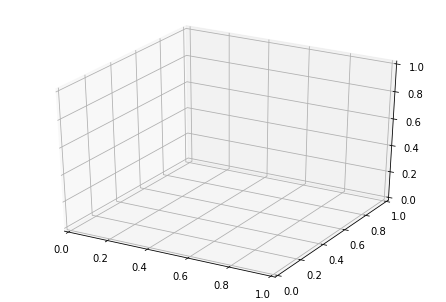

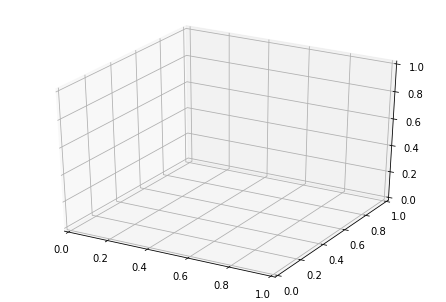

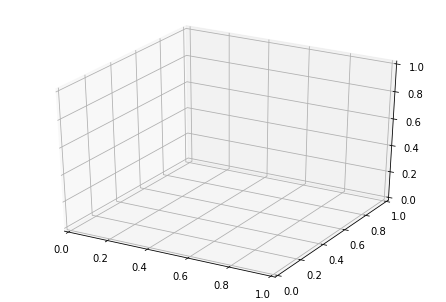

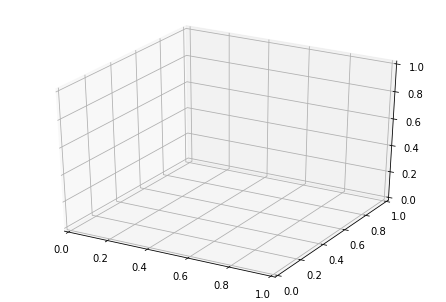

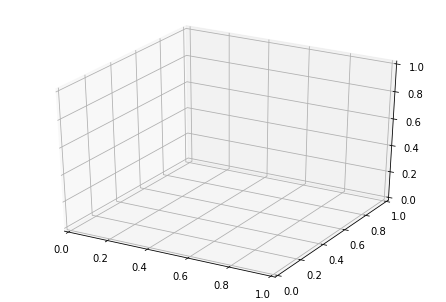

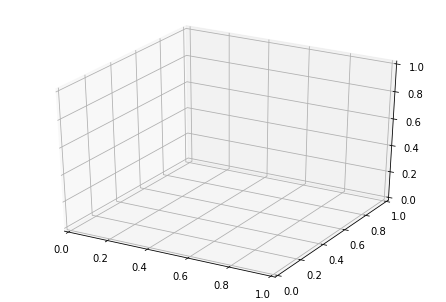

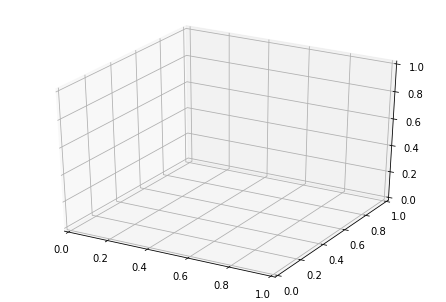

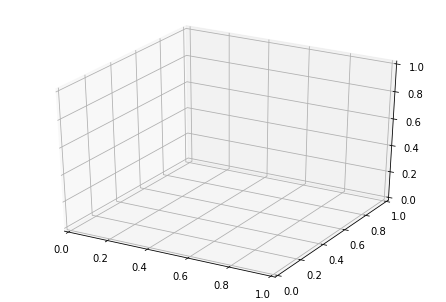

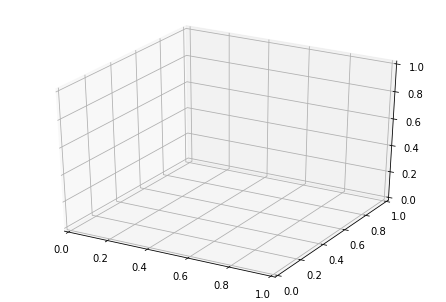

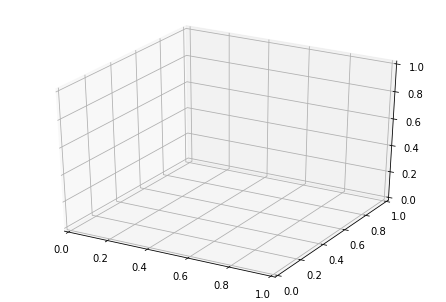

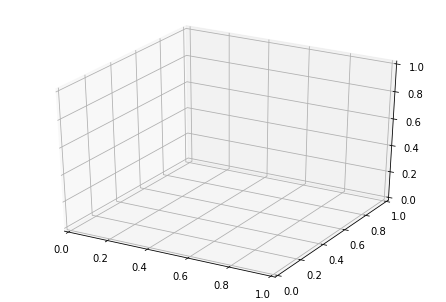

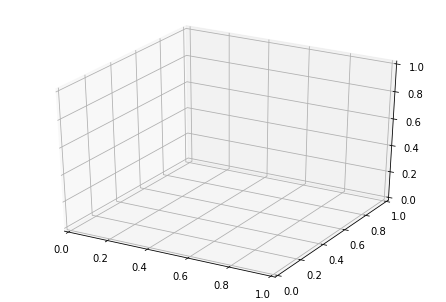

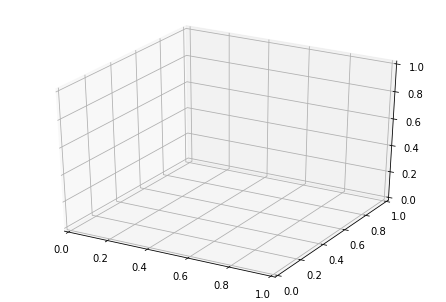

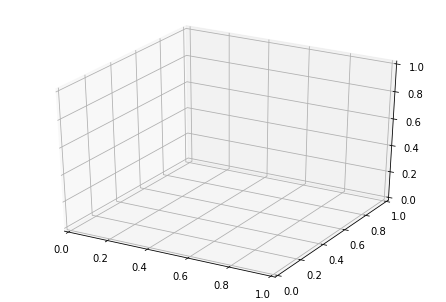

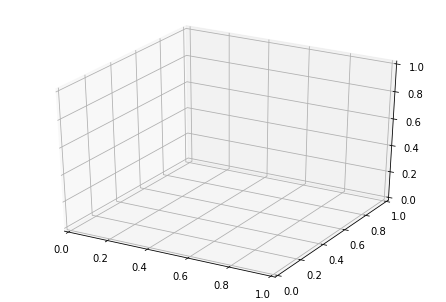

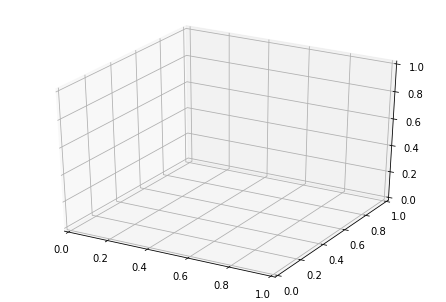

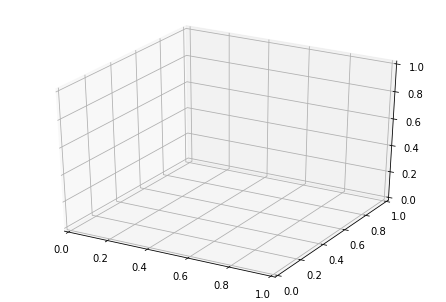

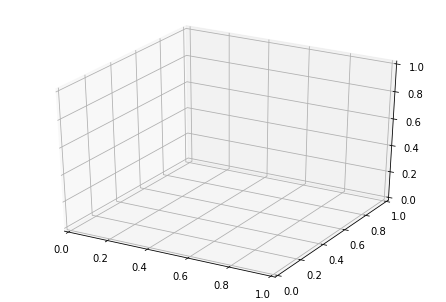

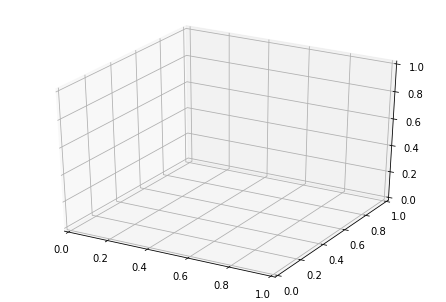

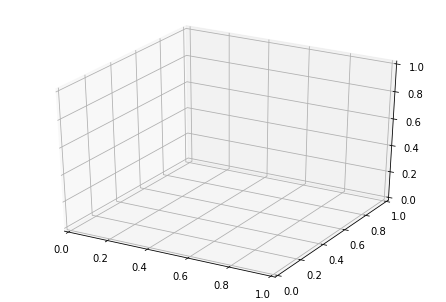

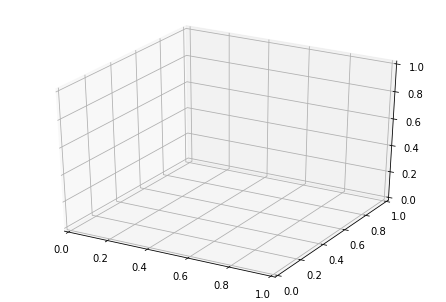

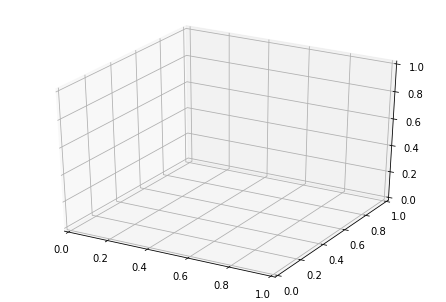

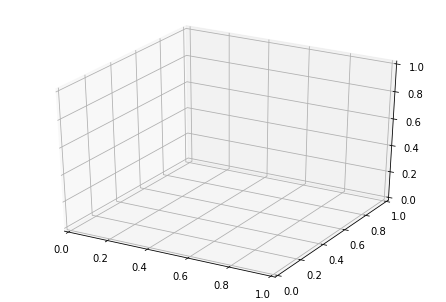

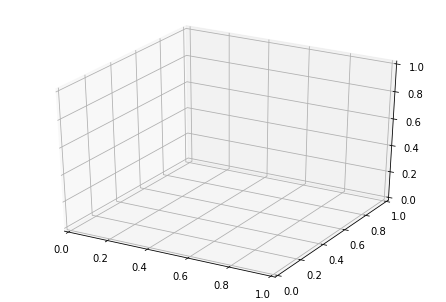

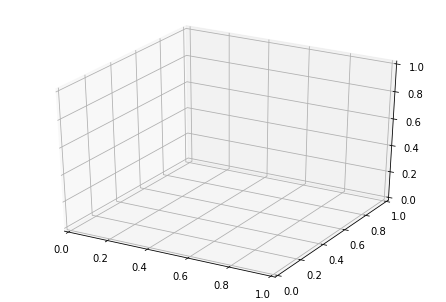

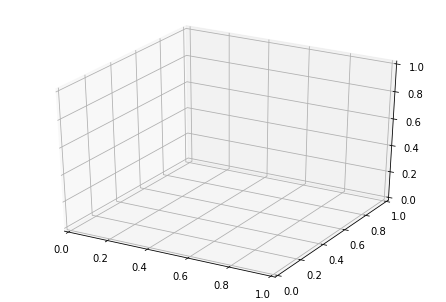

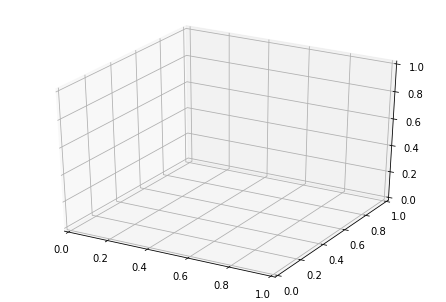

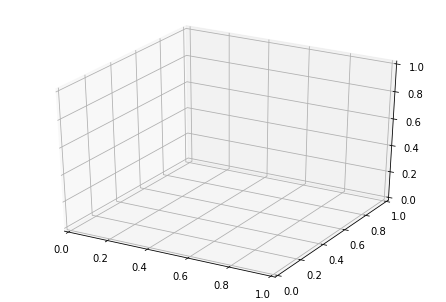

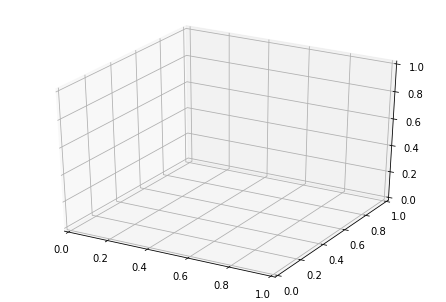

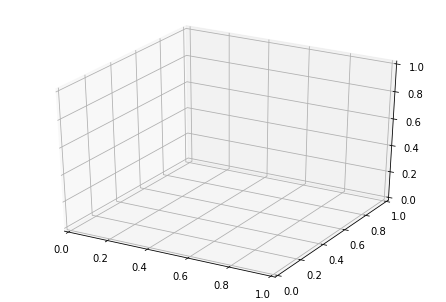

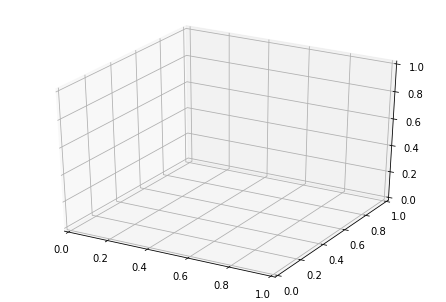

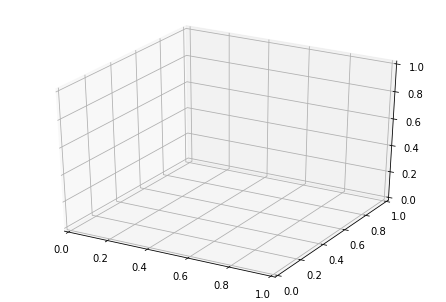

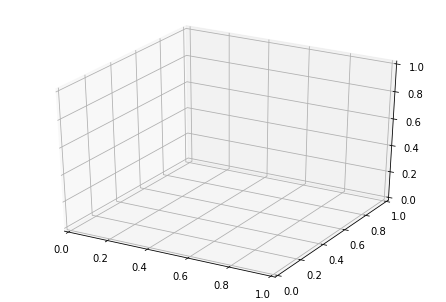

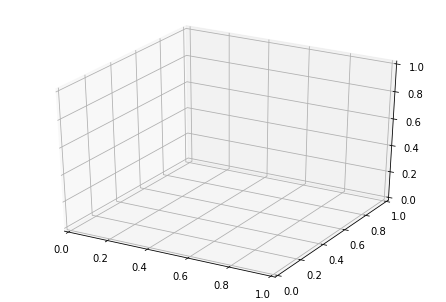

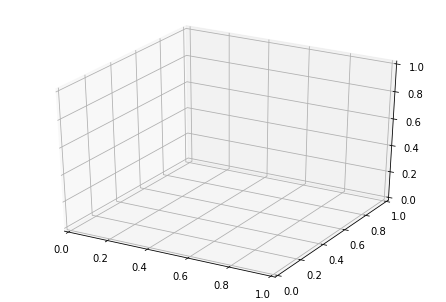

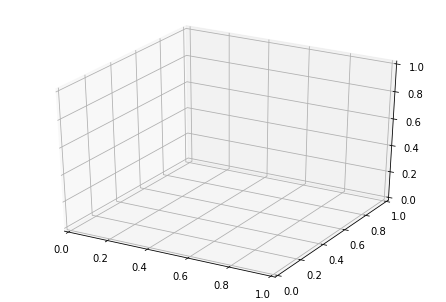

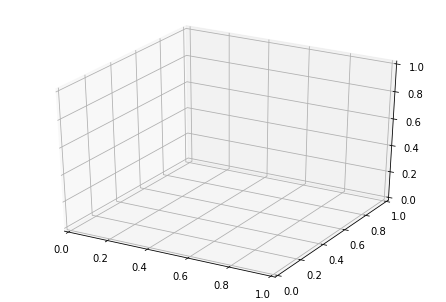

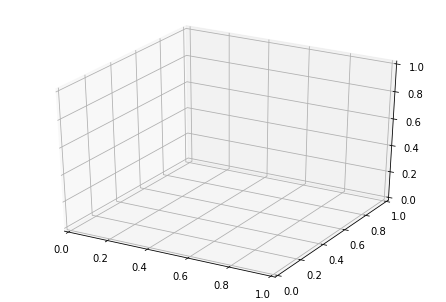

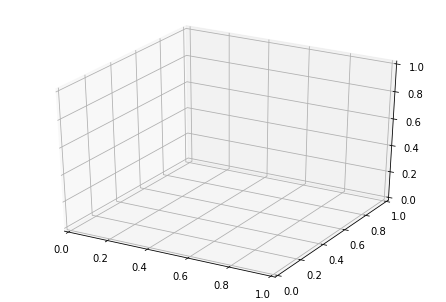

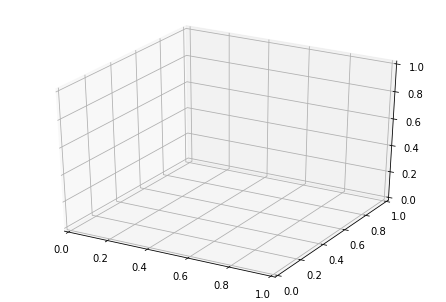

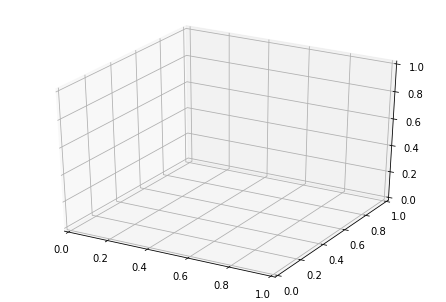

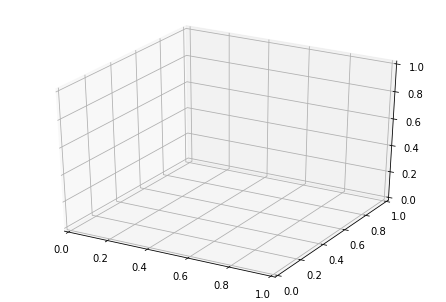

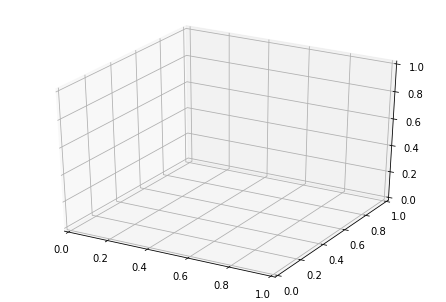

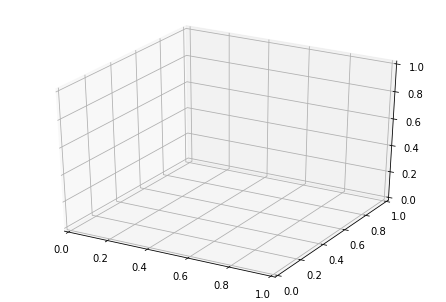

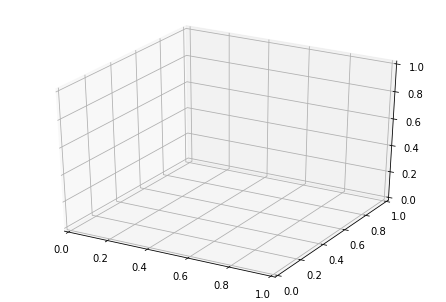

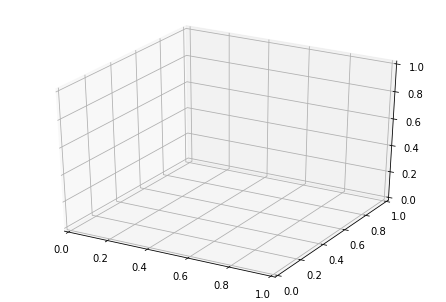

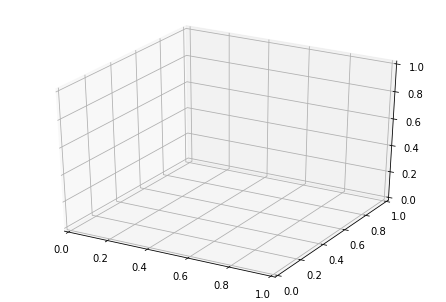

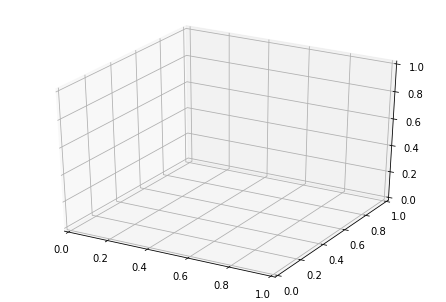

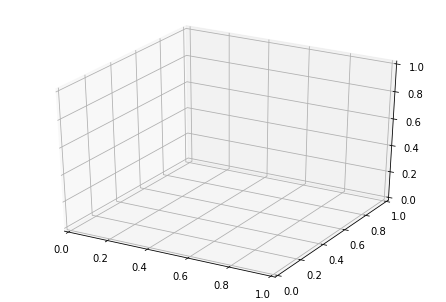

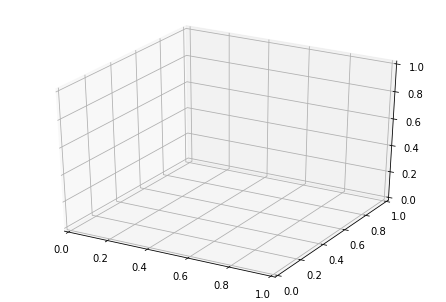

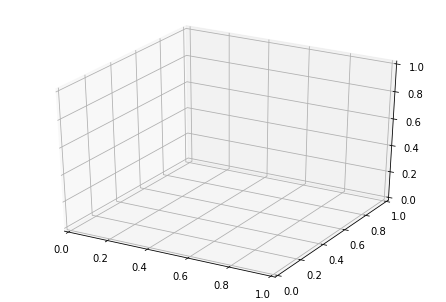

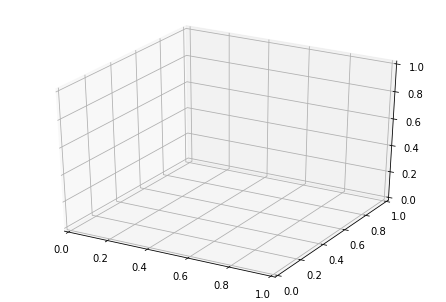

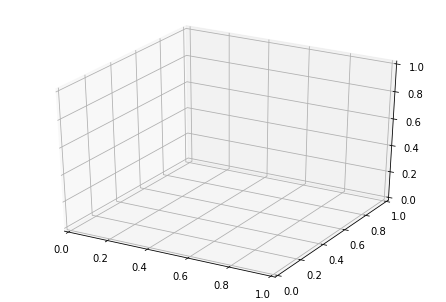

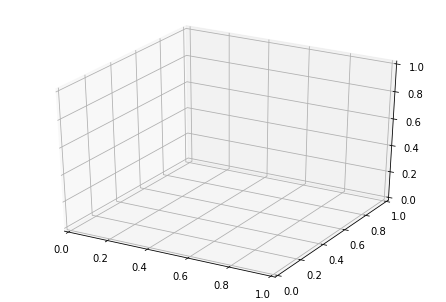

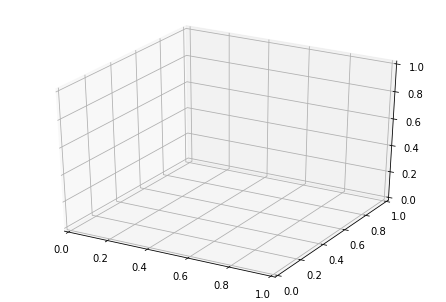

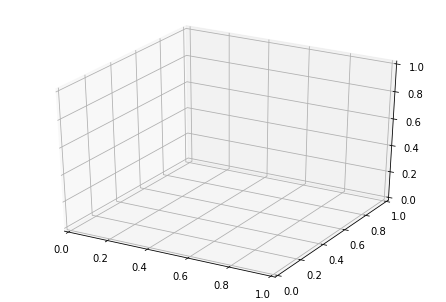

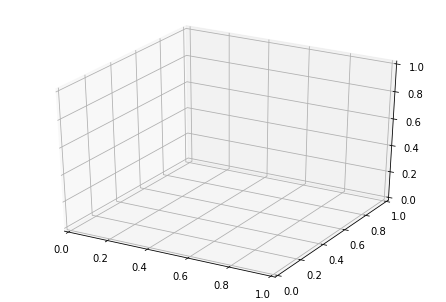

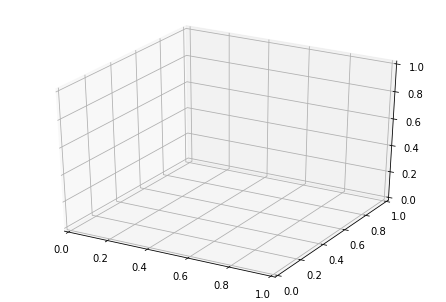

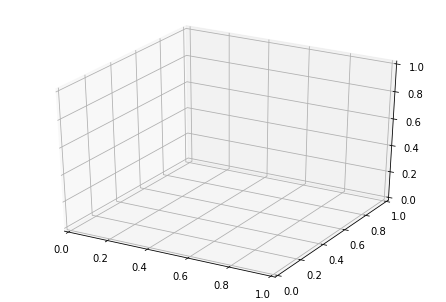

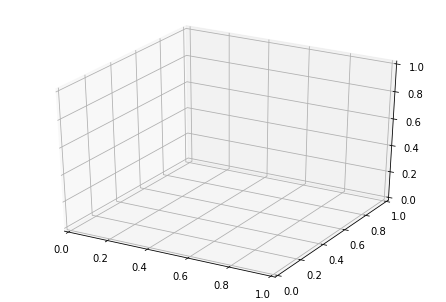

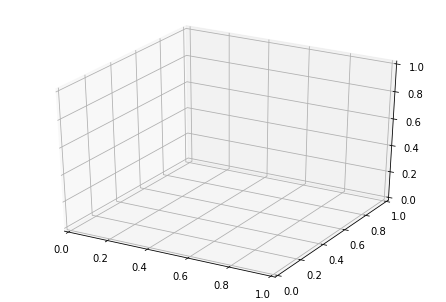

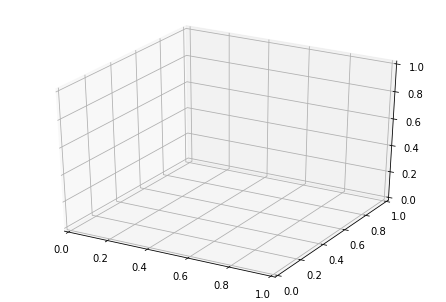

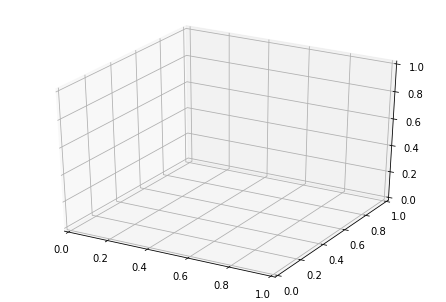

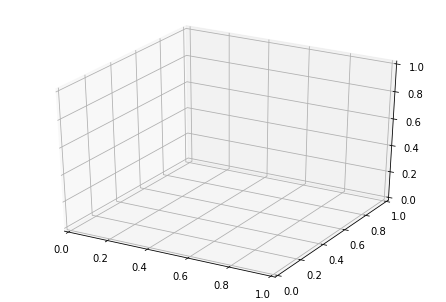

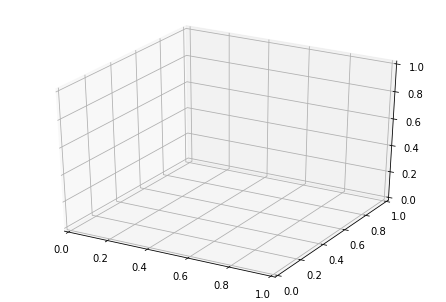

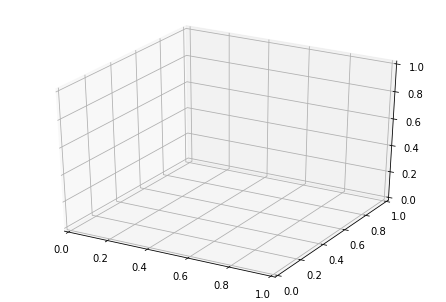

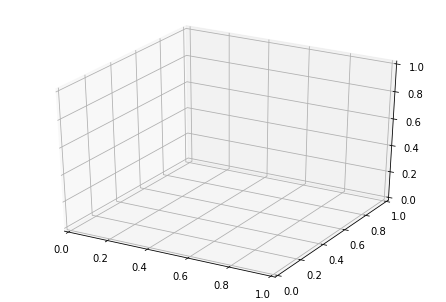

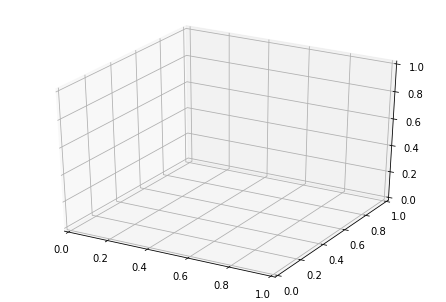

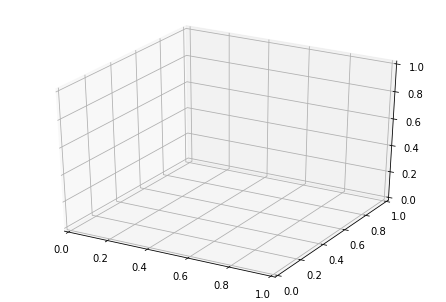

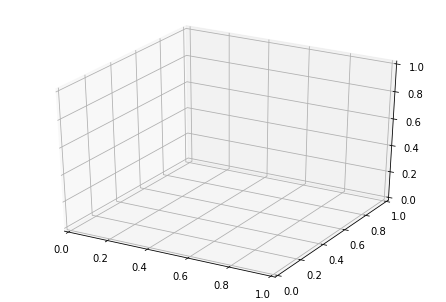

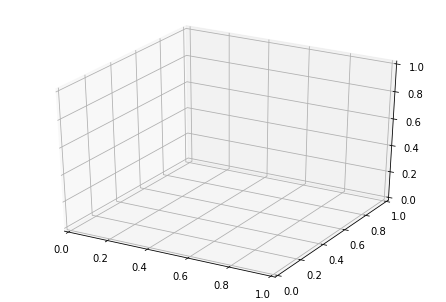

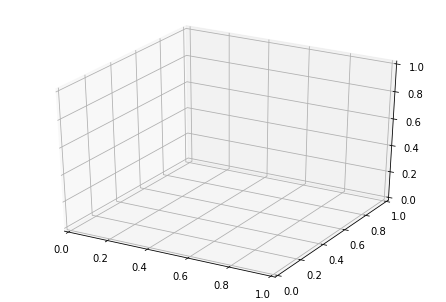

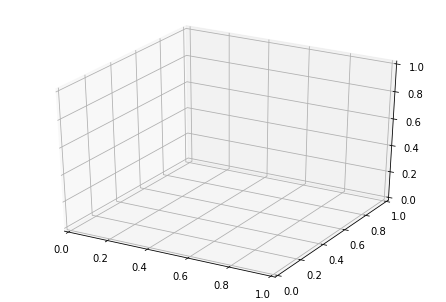

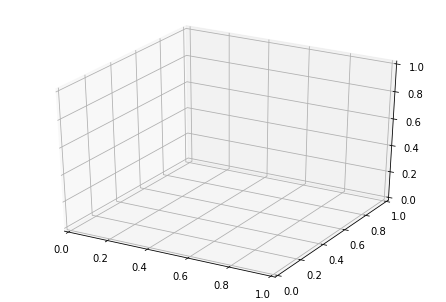

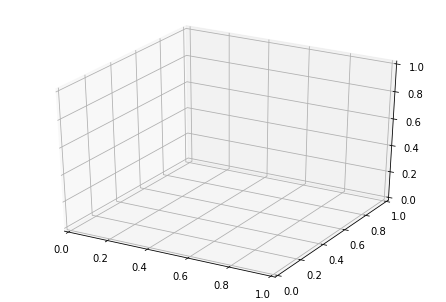

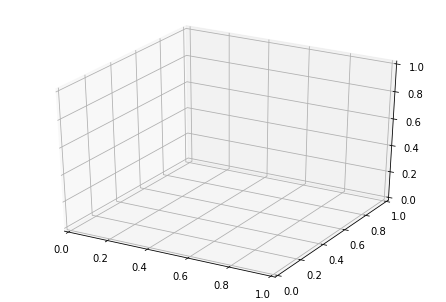

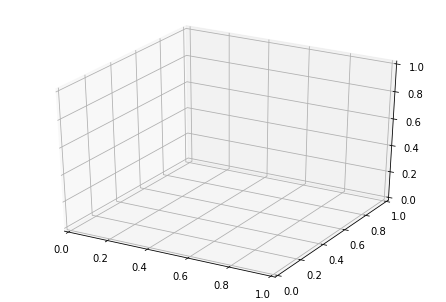

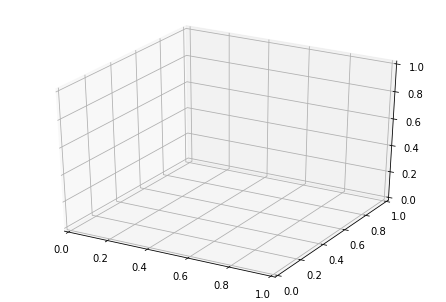

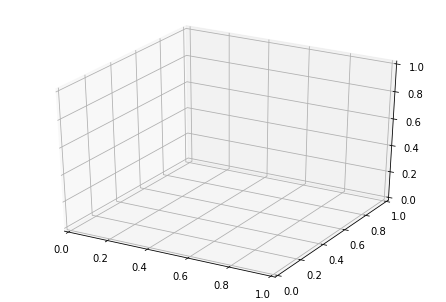

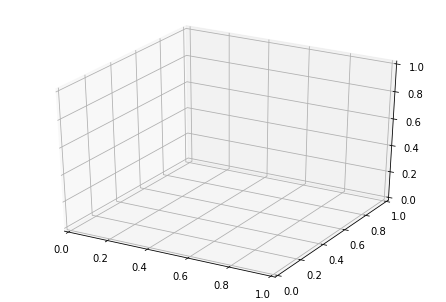

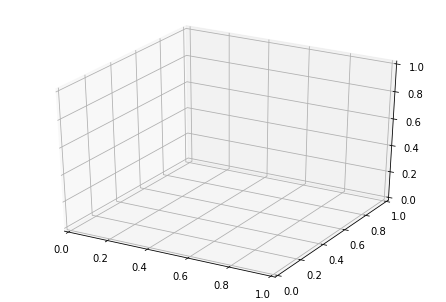

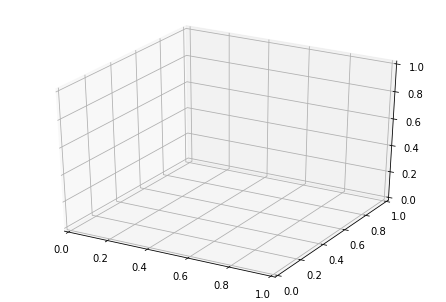

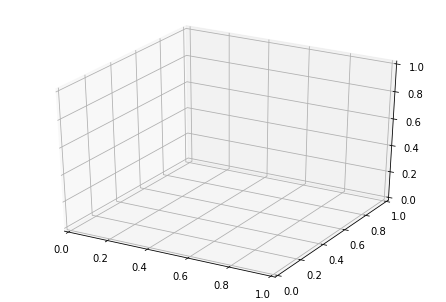

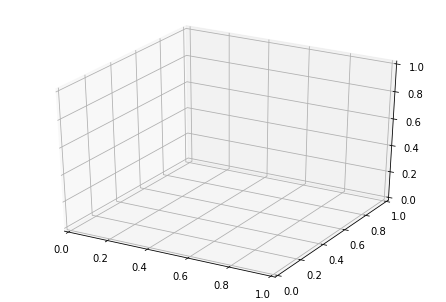

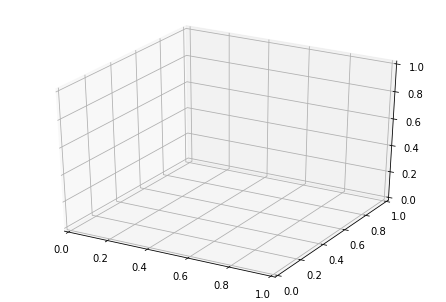

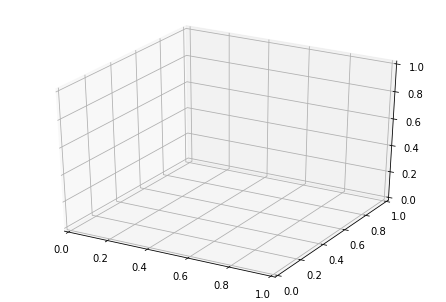

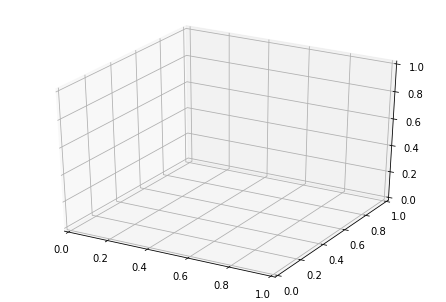

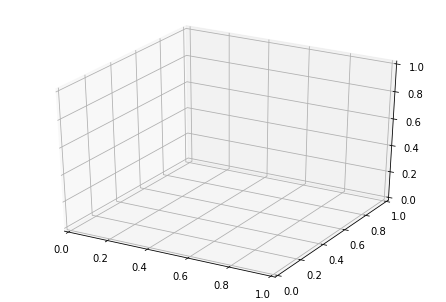

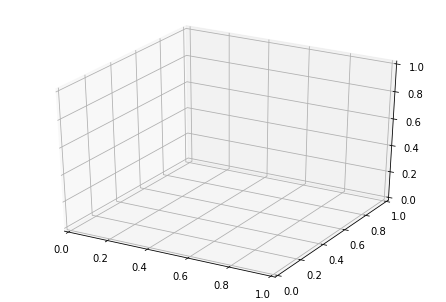

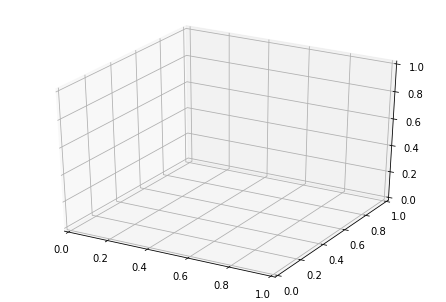

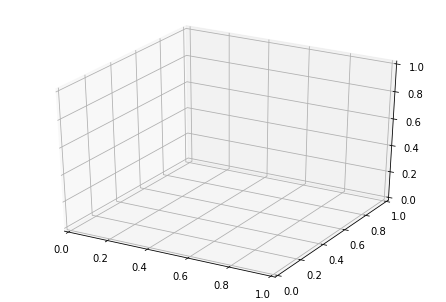

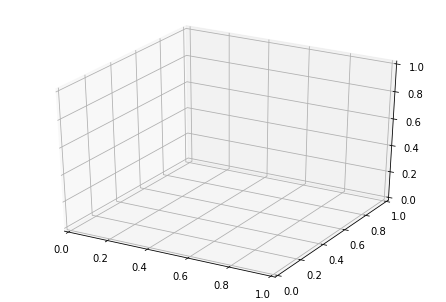

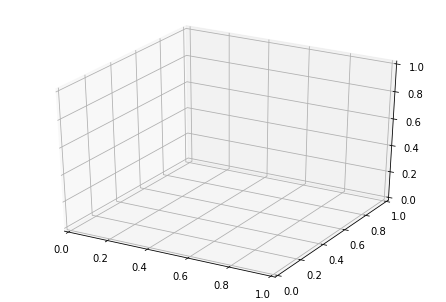

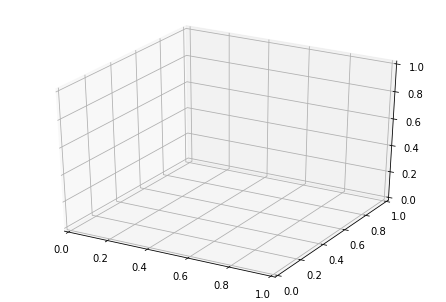

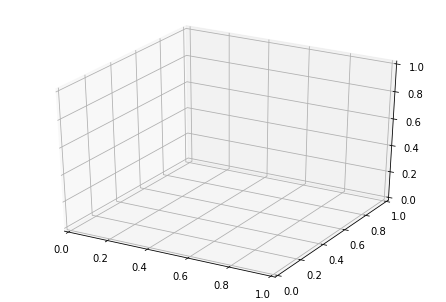

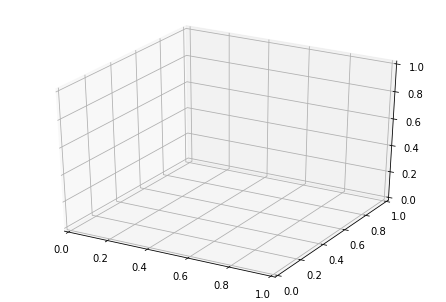

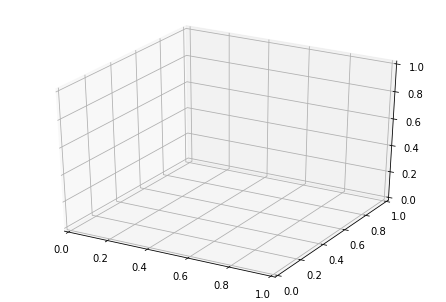

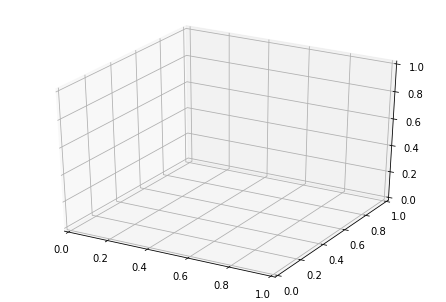

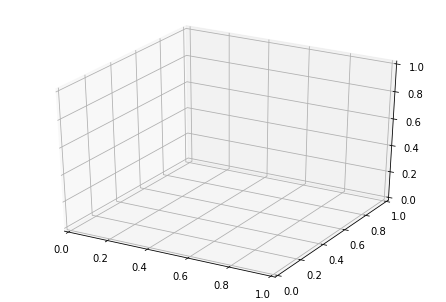

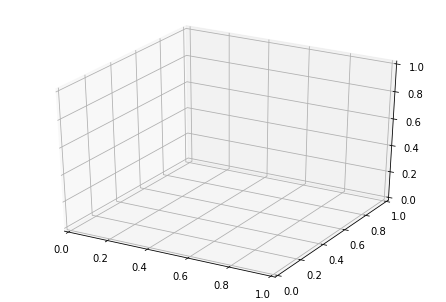

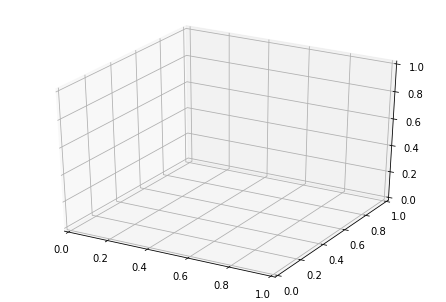

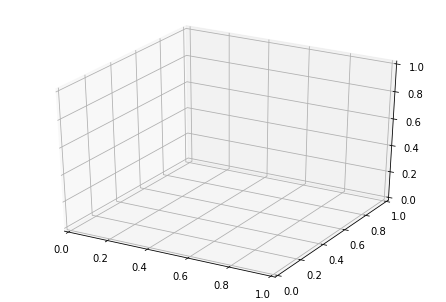

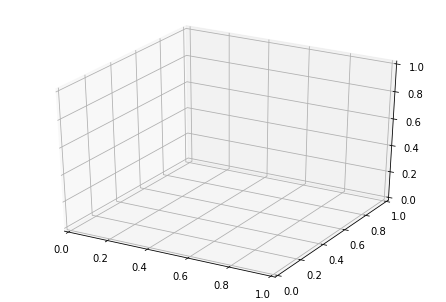

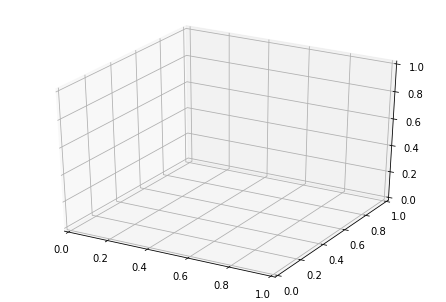

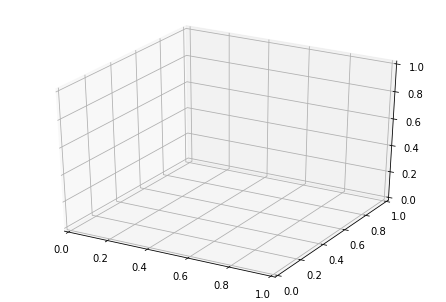

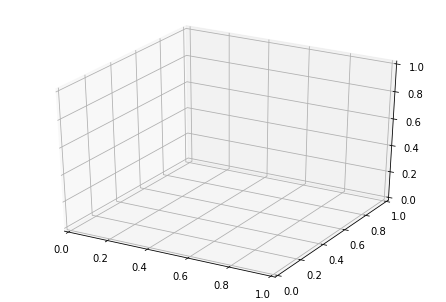

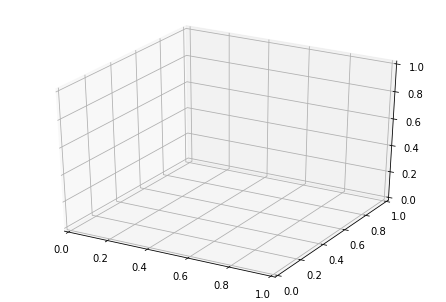

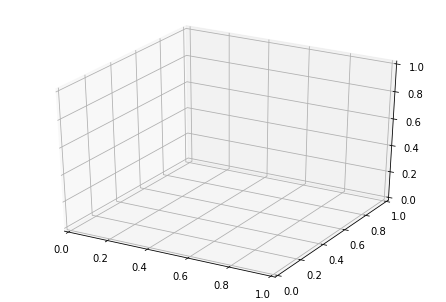

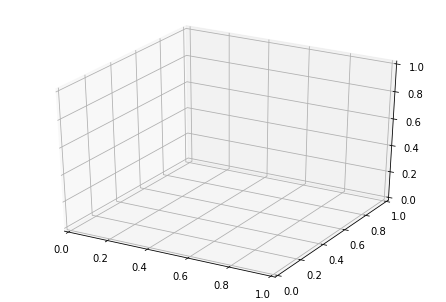

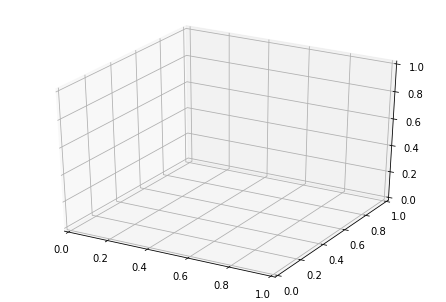

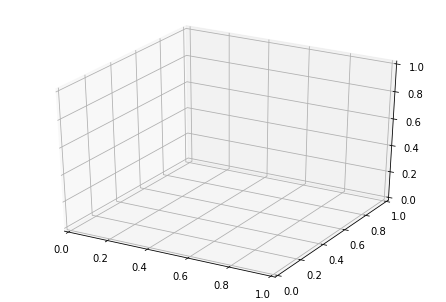

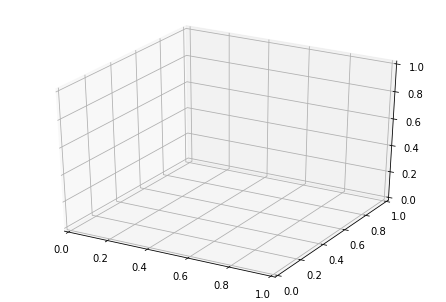

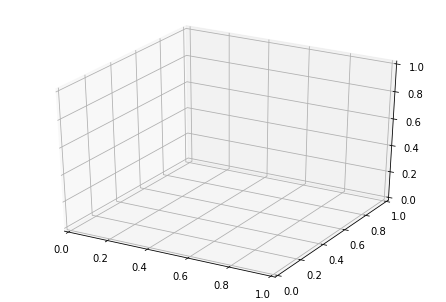

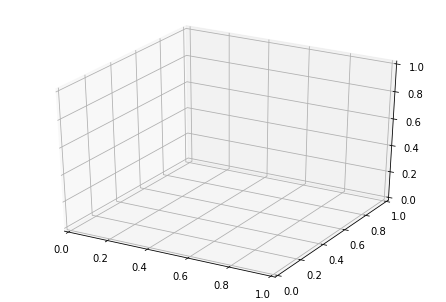

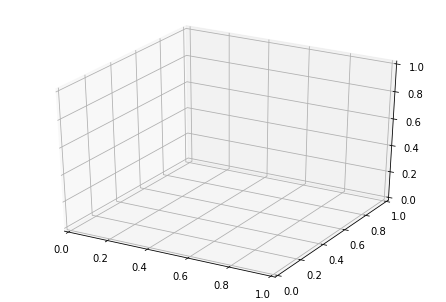

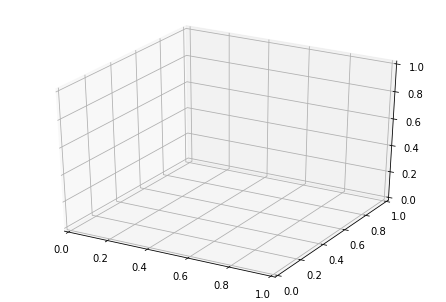

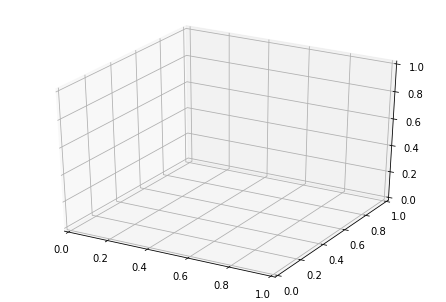

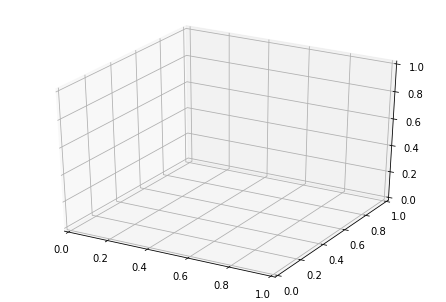

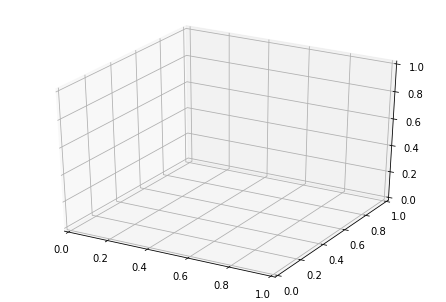

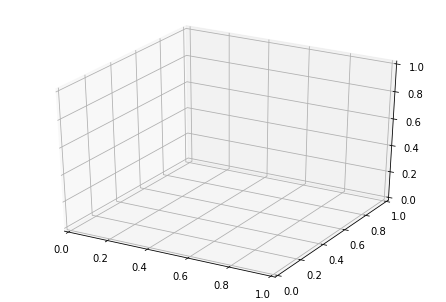

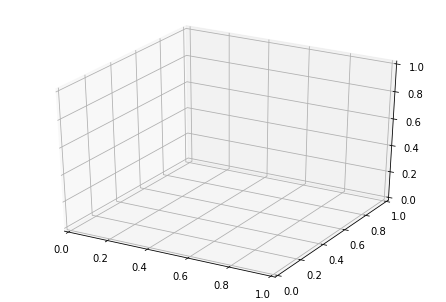

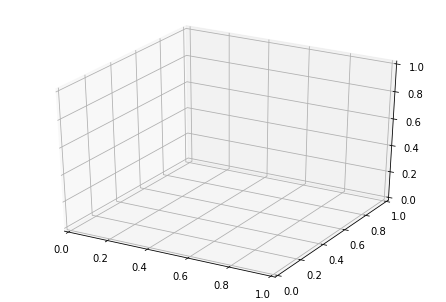

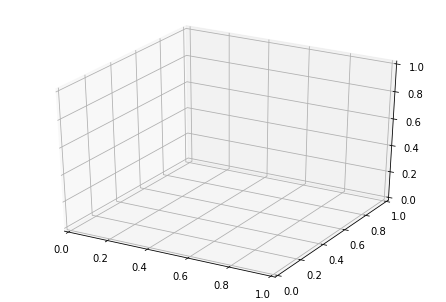

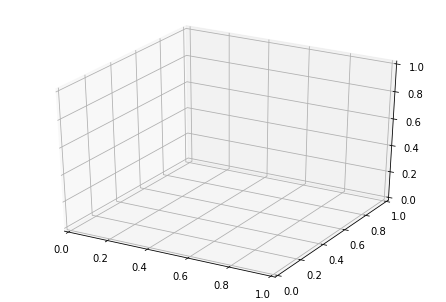

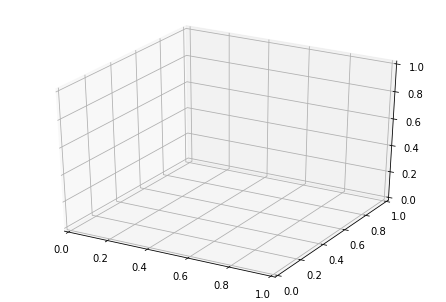

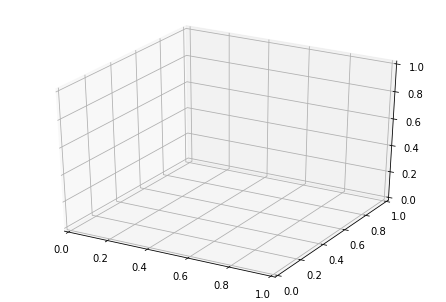

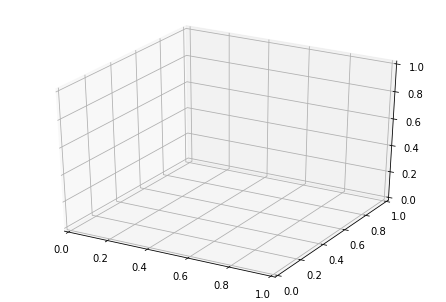

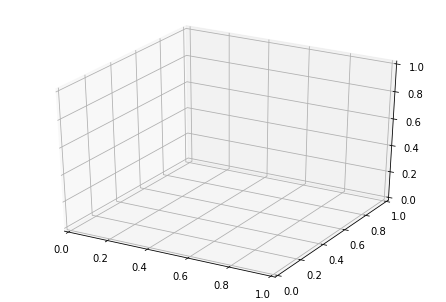

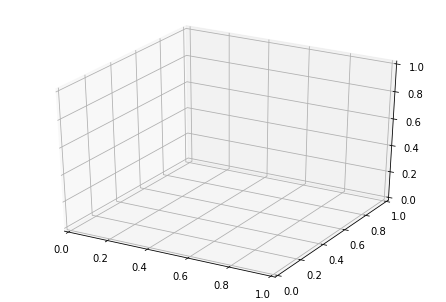

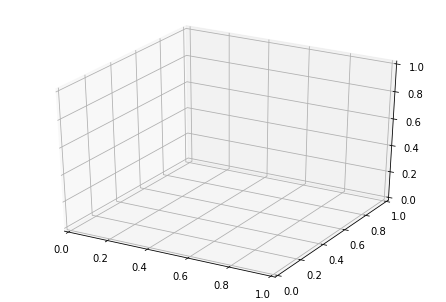

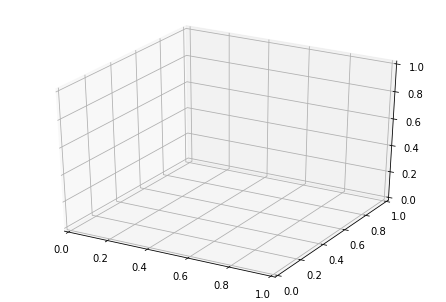

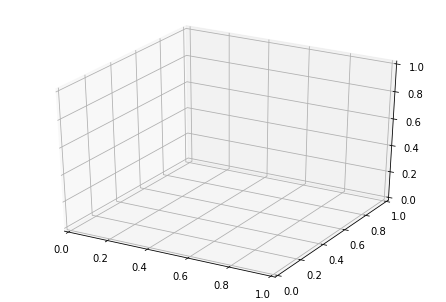

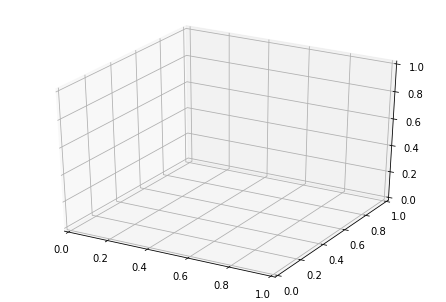

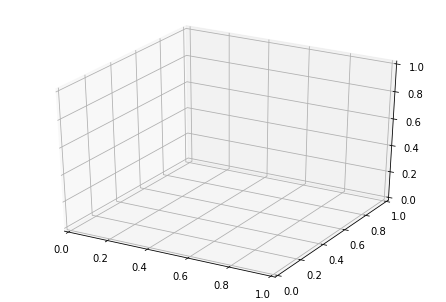

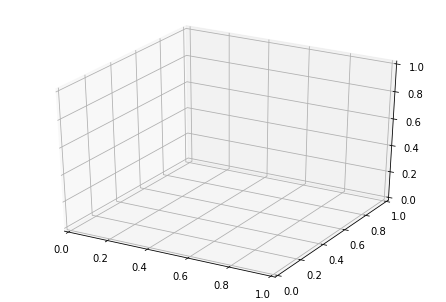

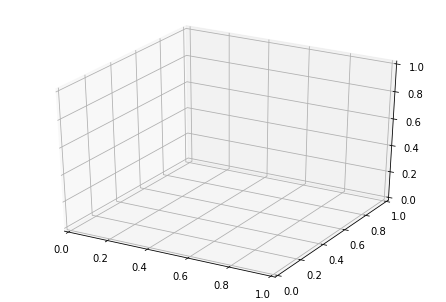

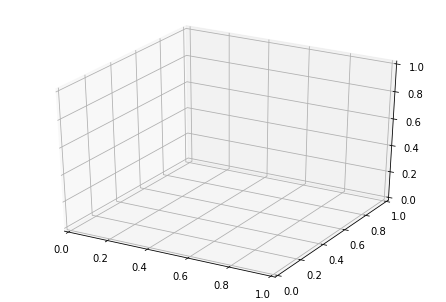

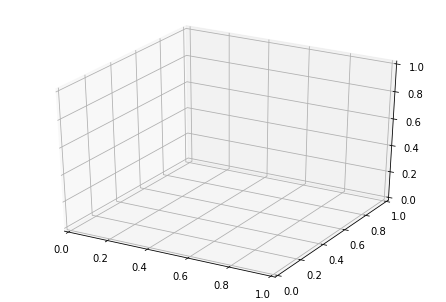

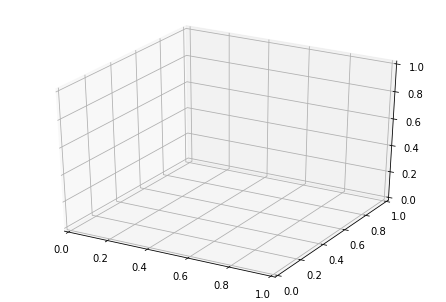

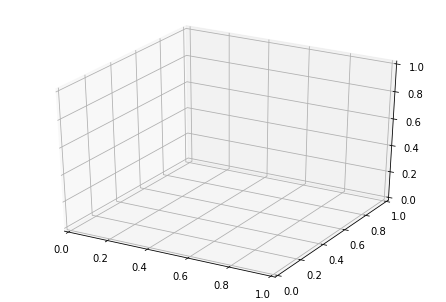

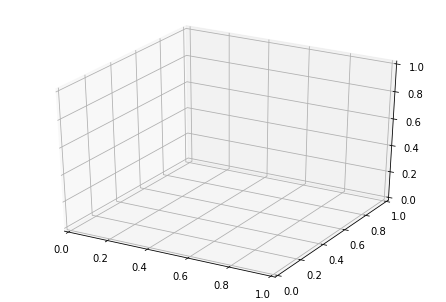

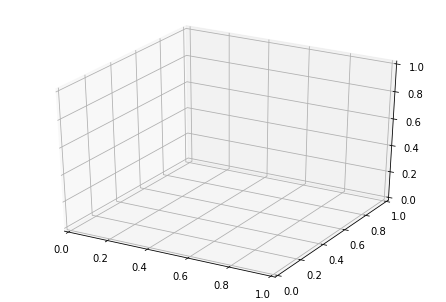

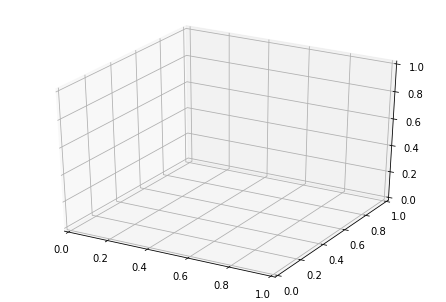

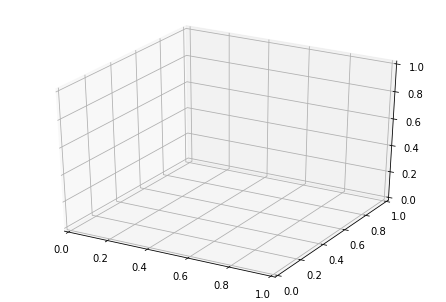

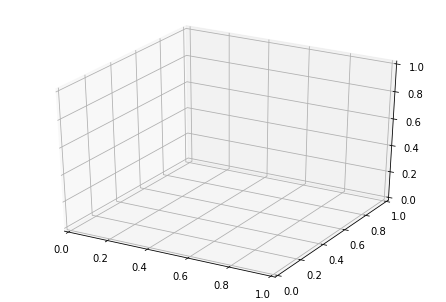

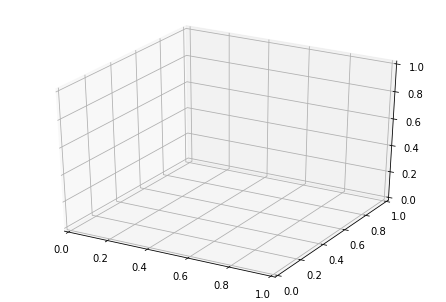

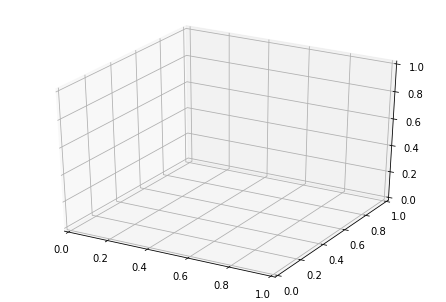

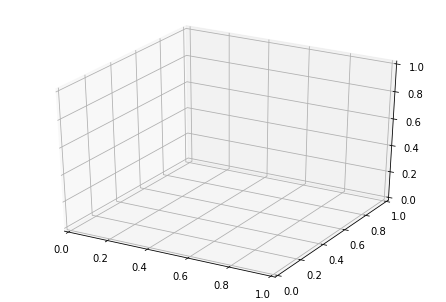

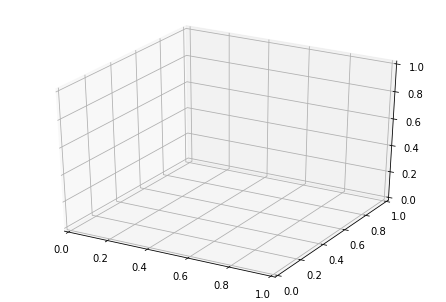

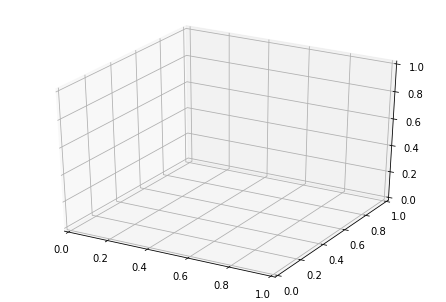

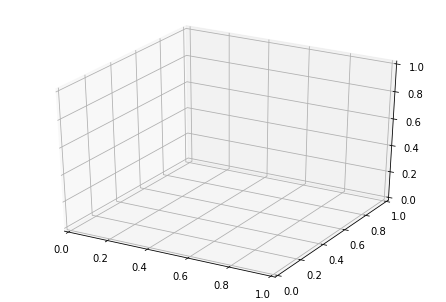

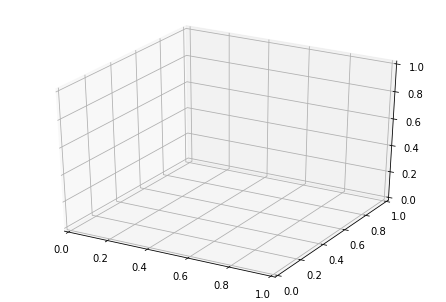

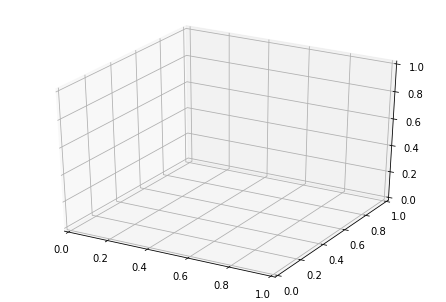

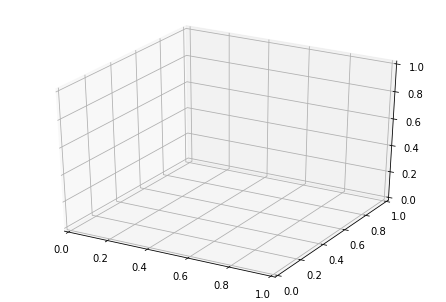

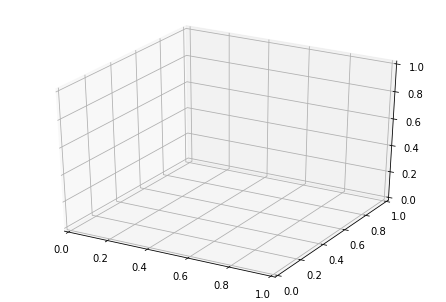

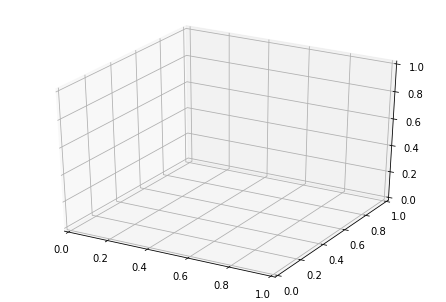

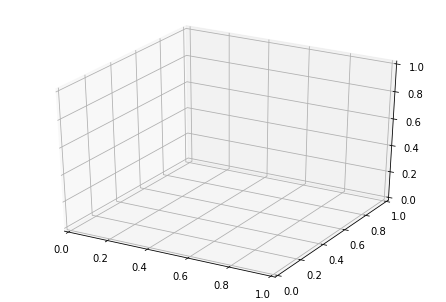

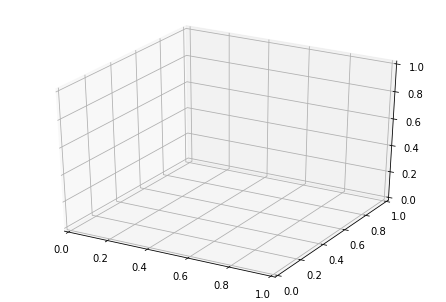

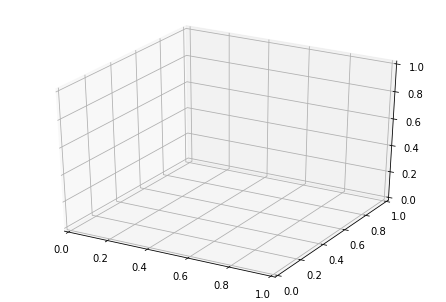

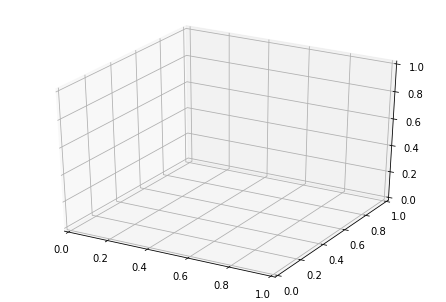

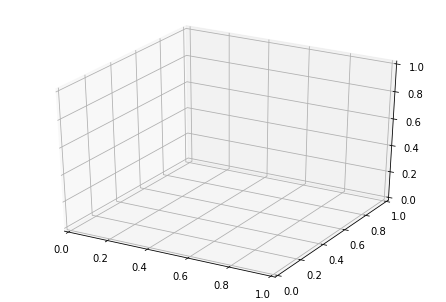

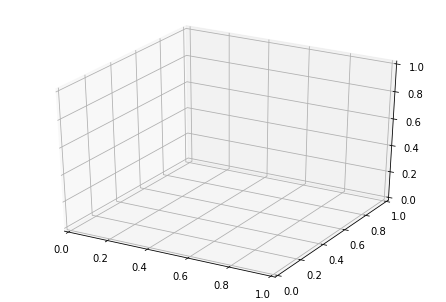

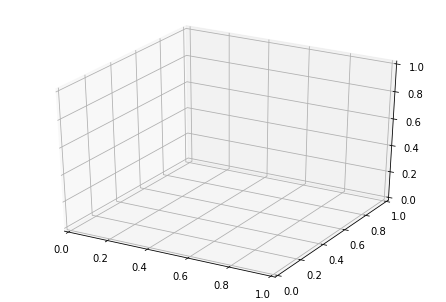

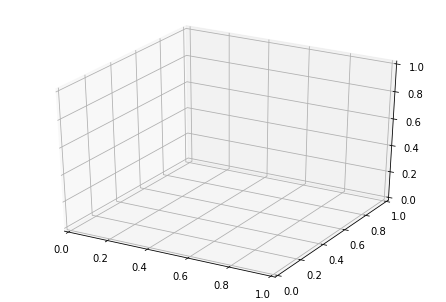

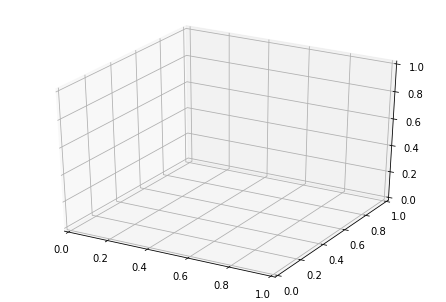

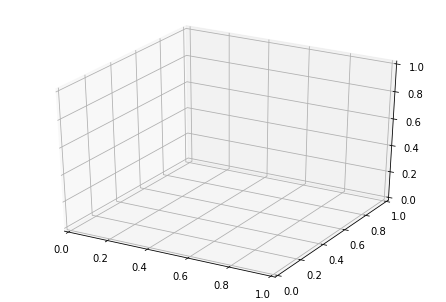

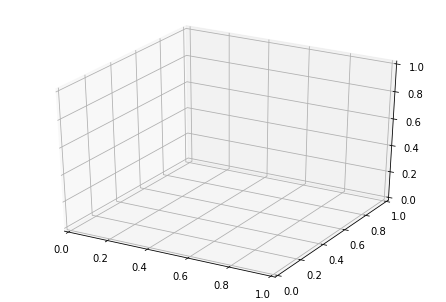

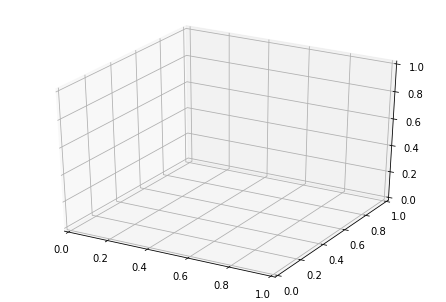

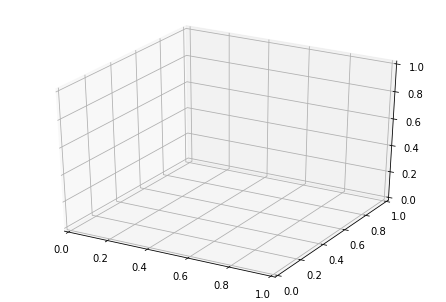

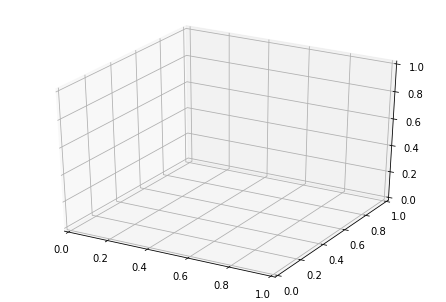

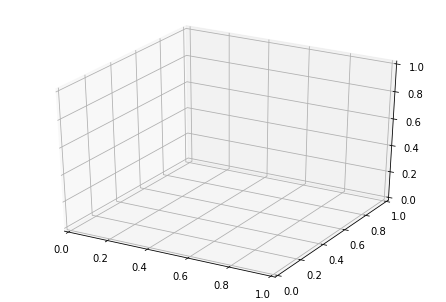

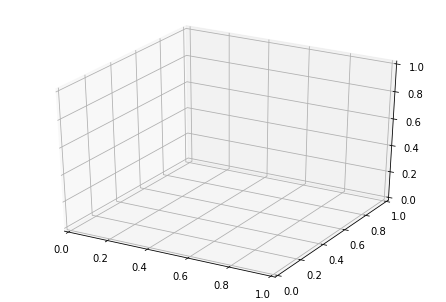

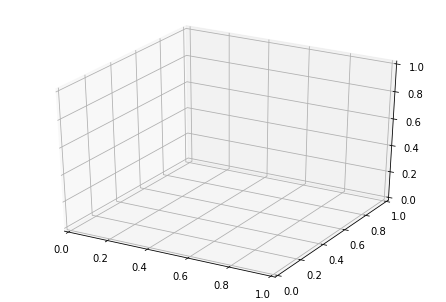

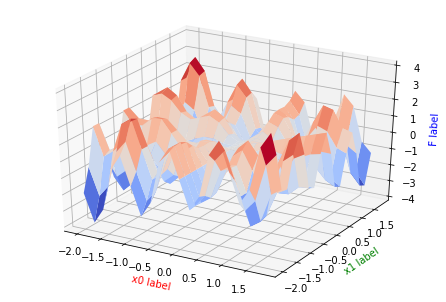

In [74]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion() #打开交互式
for _ in range(200):
    plt.cla() #清空画布
    X = Y = np.arange(-2, 2, 0.2)
    X, Y=np.meshgrid(X,Y)
    Z = func(X, Y)
    
    fig1=plt.figure()
    ax=Axes3D(fig1)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm)#做曲面
    ax.set_xlabel('x0 label', color='r')
    ax.set_ylabel('x1 label', color='g')
    ax.set_zlabel('F label', color='b')#给三个坐标轴注明
    
    ax.scatter(*list(zip(*ga.translateDNA())), ga.get_fitness(), s=100, lw=0, c='red', alpha=0.5)
    
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

    ga.evolution()

x0    1.749996
x1   -1.777348
F     2.438452
dtype: float64

In [4]:
import math, random

class Population:
    # 种群的设计
    def __init__(self, size, chrom_size, cp, mp, gen_max):
        # 种群信息合
        self.individuals = []          # 个体集合
        self.fitness = []              # 个体适应度集
        self.selector_probability = [] # 个体选择概率集合
        self.new_individuals = []      # 新一代个体集合

        self.elitist = {'chromosome':[0, 0], 'fitness':0, 'age':0} # 最佳个体的信息

        self.size = size # 种群所包含的个体数
        self.chromosome_size = chrom_size # 个体的染色体长度
        self.crossover_probability = cp   # 个体之间的交叉概率
        self.mutation_probability = mp    # 个体之间的变异概率
         
        self.generation_max = gen_max # 种群进化的最大世代数
        self.age = 0                  # 种群当前所处世代
          
        # 随机产生初始个体集，并将新一代个体、适应度、选择概率等集合以 0 值进行初始化
        v = 2 ** self.chromosome_size - 1
        for i in range(self.size):
            self.individuals.append([random.randint(0, v), random.randint(0, v)])
            self.new_individuals.append([0, 0])
            self.fitness.append(0)
            self.selector_probability.append(0)

    # 基于轮盘赌博机的选择
    def decode(self, interval, chromosome):
        '''将一个染色体 chromosome 映射为区间 interval 之内的数值'''
        d = interval[1] - interval[0]
        n = float (2 ** self.chromosome_size -1)
        return (interval[0] + chromosome * d / n)
     
    def fitness_func(self, chrom1, chrom2):
        '''适应度函数，可以根据个体的两个染色体计算出该个体的适应度'''
        interval = [-10.0, 10.0]
        (x, y) = (self.decode(interval, chrom1), 
                  self.decode(interval, chrom2))
        n = lambda x, y: math.sin(math.sqrt(x*x + y*y)) ** 2 - 0.5
        d = lambda x, y: (1 + 0.001 * (x*x + y*y)) ** 2
        func = lambda x, y: 0.5 - n(x, y)/d(x, y)
        return func(x, y)
         
    def evaluate(self):
        '''用于评估种群中的个体集合 self.individuals 中各个个体的适应度'''
        sp = self.selector_probability
        for i in range (self.size):
            self.fitness[i] = self.fitness_func (self.individuals[i][0],   # 将计算结果保存在 self.fitness 列表中
                                                 self.individuals[i][1])
        ft_sum = sum (self.fitness)
        for i in range (self.size):
            sp[i] = self.fitness[i] / float (ft_sum)   # 得到各个个体的生存概率
        for i in range (1, self.size):
            sp[i] = sp[i] + sp[i-1]   # 需要将个体的生存概率进行叠加，从而计算出各个个体的选择概率

    # 轮盘赌博机（选择）
    def select(self):
        (t, i) = (random.random(), 0)
        for p in self.selector_probability:
            if p > t:
                break
            i = i + 1
        return i

    # 交叉
    def cross(self, chrom1, chrom2):
        p = random.random()    # 随机概率
        n = 2 ** self.chromosome_size -1
        if chrom1 != chrom2 and p < self.crossover_probability:
            t = random.randint(1, self.chromosome_size - 1)   # 随机选择一点（单点交叉）
            mask = n << t    # << 左移运算符
            (r1, r2) = (chrom1 & mask, chrom2 & mask)   # & 按位与运算符：参与运算的两个值,如果两个相应位都为1,则该位的结果为1,否则为0
            mask = n >> (self.chromosome_size - t)
            (l1, l2) = (chrom1 & mask, chrom2 & mask)
            (chrom1, chrom2) = (r1 + l2, r2 + l1)
        return (chrom1, chrom2)

    # 变异
    def mutate(self, chrom):
        p = random.random ()
        if p < self.mutation_probability:
            t = random.randint (1, self.chromosome_size)
            mask1 = 1 << (t - 1)
            mask2 = chrom & mask1
            if mask2 > 0:
                chrom = chrom & (~mask2)  # ~ 按位取反运算符：对数据的每个二进制位取反,即把1变为0,把0变为1 
            else:
                chrom = chrom ^ mask1   # ^ 按位异或运算符：当两对应的二进位相异时，结果为1 
        return chrom

    # 保留最佳个体
    def reproduct_elitist (self):
        # 与当前种群进行适应度比较，更新最佳个体
        j = -1
        for i in range (self.size):
            if self.elitist['fitness'] < self.fitness[i]:
                j = i
                self.elitist['fitness'] = self.fitness[i]
        if (j >= 0):
            self.elitist['chromosome'][0] = self.individuals[j][0]
            self.elitist['chromosome'][1] = self.individuals[j][1]
            self.elitist['age'] = self.age

    # 进化过程
    def evolve(self):
        indvs = self.individuals
        new_indvs = self.new_individuals
        # 计算适应度及选择概率
        self.evaluate()
        # 进化操作
        i = 0
        while True:
            # 选择两个个体，进行交叉与变异，产生新的种群
            idv1 = self.select()
            idv2 = self.select()
            # 交叉
            (idv1_x, idv1_y) = (indvs[idv1][0], indvs[idv1][1])
            (idv2_x, idv2_y) = (indvs[idv2][0], indvs[idv2][1])
            (idv1_x, idv2_x) = self.cross(idv1_x, idv2_x)
            (idv1_y, idv2_y) = self.cross(idv1_y, idv2_y)
            # 变异
            (idv1_x, idv1_y) = (self.mutate(idv1_x), self.mutate(idv1_y))
            (idv2_x, idv2_y) = (self.mutate(idv2_x), self.mutate(idv2_y))
            (new_indvs[i][0], new_indvs[i][1]) = (idv1_x, idv1_y)  # 将计算结果保存于新的个体集合self.new_individuals中
            (new_indvs[i+1][0], new_indvs[i+1][1]) = (idv2_x, idv2_y)
            # 判断进化过程是否结束
            i = i + 2         # 循环self.size/2次，每次从self.individuals 中选出2个
            if i >= self.size:
                break
        
        # 最佳个体保留
        # 如果在选择之前保留当前最佳个体，最终能收敛到全局最优解。
        self.reproduct_elitist()

        # 更新换代：用种群进化生成的新个体集合 self.new_individuals 替换当前个体集合
        for i in range (self.size):
            self.individuals[i][0] = self.new_individuals[i][0]
            self.individuals[i][1] = self.new_individuals[i][1]

    def run(self):
        '''根据种群最大进化世代数设定了一个循环。
        在循环过程中，调用 evolve 函数进行种群进化计算，并输出种群的每一代的个体适应度最大值、平均值和最小值。'''
        for i in range (self.generation_max):
            self.evolve ()
            print (i, max (self.fitness), sum (self.fitness)/self.size, min (self.fitness))
if __name__ == '__main__':
    # 种群的个体数量为 50，染色体长度为 25，交叉概率为 0.8，变异概率为 0.1,进化最大世代数为 150
    pop = Population (50, 24, 0.8, 0.1, 150)
    pop.run()

0 0.9619949491271946 0.47367026649816785 0.0585586407396218
1 0.9853914074846231 0.6667901659825091 0.022721803297217513
2 0.9853914074846231 0.7001916249642574 0.029230844777291654
3 0.9853909326410268 0.6590632290149423 0.036406259940340246
4 0.9887046382313529 0.7481713971569414 0.07102143820702689
5 0.9887246089858583 0.7058530203336306 0.0033435471484422608
6 0.98184148900832 0.7418903104156417 0.05678510110737067
7 0.9832069808921182 0.756810902046968 0.21031698579432728
8 0.9831830604152813 0.7917304669542253 0.07021370507562164
9 0.9627734640761652 0.766219414258152 0.0876105480977668
10 0.9618957923517397 0.7556155330962925 0.09169532097524324
11 0.9624060090134301 0.7780588388741139 0.15704881131645038
12 0.9621326614089288 0.7051161030129073 0.04527809618746109
13 0.9610052102245623 0.7624440041278061 0.157127996264265
14 0.9573706464415902 0.797863946063185 0.2155985853066354
15 0.9576870309180257 0.730492635506687 0.16275004031206075
16 0.9592587764598123 0.74984961451484 

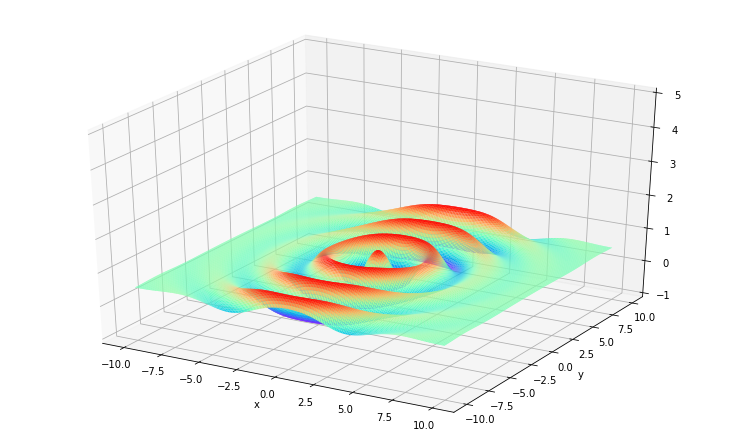

In [82]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
x = np.arange(-10, 10, 0.1)
y = np.arange(-10, 10, 0.1)
X, Y = np.meshgrid(x, y)       
Z = 0.5 - (np.sin(np.sqrt(X**2+Y**2))**2 - 0.5)/(1 + 0.001*(x**2 + y**2)**2)
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlim([-1,5])
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='rainbow')
plt.show()

In [83]:
random.randint(0, 100)

17